Credit Card Fraud Detection Using Machine Learning

In [61]:
#!pip install scikit-learn-intelex
#!pip install mlxtend
#!pip install tpot
#!pip install xgboost
#!pip install hyperopt
#!pip install imblearn
#!pip install xlwt

In [43]:
from sklearnex import patch_sklearn  #This is a library to vaccelerate existing scikit-learn code
patch_sklearn() #For more info: https://github.com/intel/scikit-learn-intelex

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from tpot import TPOTClassifier
from mlxtend.classifier import StackingCVClassifier

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, accuracy_score, average_precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from imblearn.pipeline import make_pipeline
from scipy.stats import uniform, randint
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.over_sampling import SMOTE
import hyperopt 
from hyperopt.pyll import scope
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
from collections import Counter

import warnings
warnings.filterwarnings("ignore")
np.random.seed(0)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


General information about the data:

In [63]:
credit_card=pd.read_csv("creditcard.csv")
credit_card.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000,-1.360,-0.073,2.536,1.378,-0.338,0.462,0.240,0.099,0.364,...,-0.018,0.278,-0.110,0.067,0.129,-0.189,0.134,-0.021,149.620,0
1,0.000,1.192,0.266,0.166,0.448,0.060,-0.082,-0.079,0.085,-0.255,...,-0.226,-0.639,0.101,-0.340,0.167,0.126,-0.009,0.015,2.690,0
2,1.000,-1.358,-1.340,1.773,0.380,-0.503,1.800,0.791,0.248,-1.515,...,0.248,0.772,0.909,-0.689,-0.328,-0.139,-0.055,-0.060,378.660,0
3,1.000,-0.966,-0.185,1.793,-0.863,-0.010,1.247,0.238,0.377,-1.387,...,-0.108,0.005,-0.190,-1.176,0.647,-0.222,0.063,0.061,123.500,0
4,2.000,-1.158,0.878,1.549,0.403,-0.407,0.096,0.593,-0.271,0.818,...,-0.009,0.798,-0.137,0.141,-0.206,0.502,0.219,0.215,69.990,0


In [4]:
pd.set_option('display.float_format', '{:.2f}'.format)
credit_card.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,...,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00
mean,94813.86,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,...,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,88.35,0.00
std,47488.15,1.96,1.65,1.52,1.42,1.38,1.33,1.24,1.19,1.10,...,0.73,0.73,0.62,0.61,0.52,0.48,0.40,0.33,250.12,0.04
min,0.00,-56.41,-72.72,-48.33,-5.68,-113.74,-26.16,-43.56,-73.22,-13.43,...,-34.83,-10.93,-44.81,-2.84,-10.30,-2.60,-22.57,-15.43,0.00,0.00
25%,54201.50,-0.92,-0.60,-0.89,-0.85,-0.69,-0.77,-0.55,-0.21,-0.64,...,-0.23,-0.54,-0.16,-0.35,-0.32,-0.33,-0.07,-0.05,5.60,0.00
50%,84692.00,0.02,0.07,0.18,-0.02,-0.05,-0.27,0.04,0.02,-0.05,...,-0.03,0.01,-0.01,0.04,0.02,-0.05,0.00,0.01,22.00,0.00
75%,139320.50,1.32,0.80,1.03,0.74,0.61,0.40,0.57,0.33,0.60,...,0.19,0.53,0.15,0.44,0.35,0.24,0.09,0.08,77.16,0.00
max,172792.00,2.45,22.06,9.38,16.88,34.80,73.30,120.59,20.01,15.59,...,27.20,10.50,22.53,4.58,7.52,3.52,31.61,33.85,25691.16,1.00


In [62]:
credit_card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype   
---  ------  --------------   -----   
 0   Time    284807 non-null  float64 
 1   V1      284807 non-null  float64 
 2   V2      284807 non-null  float64 
 3   V3      284807 non-null  float64 
 4   V4      284807 non-null  float64 
 5   V5      284807 non-null  float64 
 6   V6      284807 non-null  float64 
 7   V7      284807 non-null  float64 
 8   V8      284807 non-null  float64 
 9   V9      284807 non-null  float64 
 10  V10     284807 non-null  float64 
 11  V11     284807 non-null  float64 
 12  V12     284807 non-null  float64 
 13  V13     284807 non-null  float64 
 14  V14     284807 non-null  float64 
 15  V15     284807 non-null  float64 
 16  V16     284807 non-null  float64 
 17  V17     284807 non-null  float64 
 18  V18     284807 non-null  float64 
 19  V19     284807 non-null  float64 
 20  V20     284807 non-null  f

Class needed to be categorical.

In [6]:
credit_card["Class"]=credit_card["Class"].astype("category")

Let' see if there are any null.

In [7]:
print(credit_card.isna().any().sum())

0


Let's see how many transactions are fraudulent.

In [8]:
credit_card["Class"].value_counts()

0    284315
1       492
Name: Class, dtype: int64

It's are extremly imbalanced

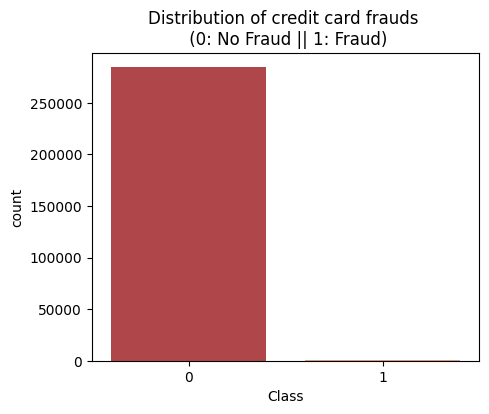

In [9]:
sns.set_palette("RdBu")
fig, ax = plt.subplots(figsize=(5,4))
bar = sns.countplot(x=credit_card["Class"],ax=ax)
bar.set_title('Distribution of credit card frauds \n (0: No Fraud || 1: Fraud)')
plt.show()

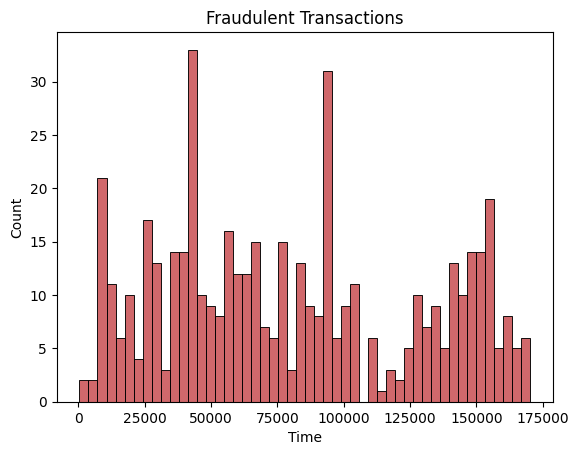

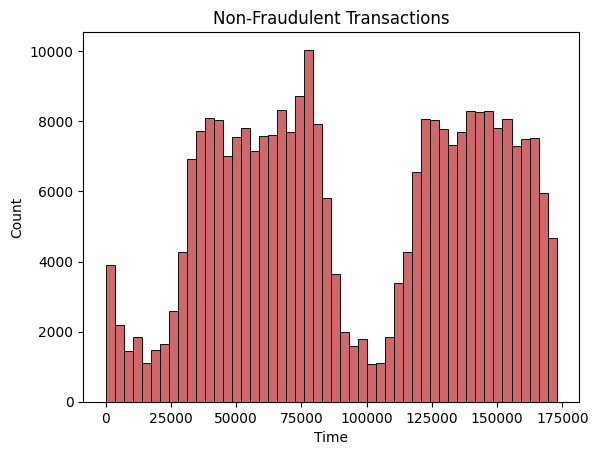

In [10]:
g1 = sns.histplot(credit_card["Time"][credit_card.Class == 1], bins=50)
g1.set_title("Fraudulent Transactions")
plt.show()
g1 = sns.histplot(credit_card["Time"][credit_card.Class == 0], bins=50)
g1.set_title("Non-Fraudulent Transactions")
plt.show()

Text(0.5, 1.0, 'Distribution of Transaction Amount')

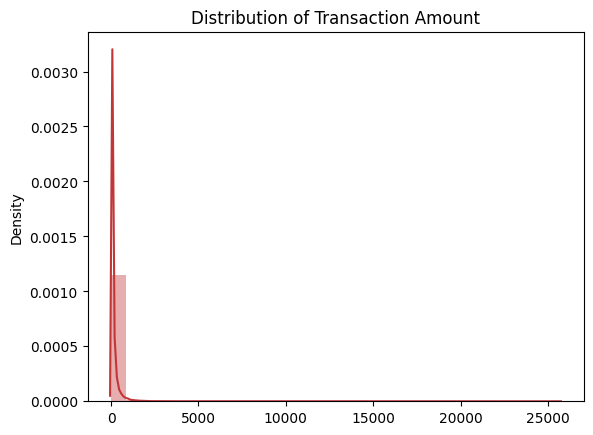

In [11]:
amount_v=credit_card["Amount"]
rel = sns.distplot(x=credit_card["Amount"],bins=30)
rel.set_title('Distribution of Transaction Amount')

In [12]:
X = credit_card.drop("Class", axis=1).values
y=credit_card["Class"].values
rand_state=42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=rand_state, stratify=y)

In [13]:
#Scale the data
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
results= pd.DataFrame(columns=["Function Name", "Accuracy", "Precision", "Recall", "F1",
                               "TN", "FP", "FN", "TP", "ROC-AUC Score", "Precision-Recall Score", "Train CV AP Score"])

In [15]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=rand_state) #We use stratified becuse of imbalanced dataset. 

In [16]:
def cross_val_score_for_sampling(model, X_train=X_train_scaled, X_test=X_test_scaled, cv=kf, 
                                 y_train=y_train, y_test=y_test, results=results, undersample=False, oversample=False, stack=False):  
    sample_accuracy = []
    sample_precision = []
    sample_recall = []
    sample_f1 = []
    sample_auc = []
    sample_ap = []   

    for train, test in cv.split(X_train, y_train):
        if oversample:
            sample_pipeline = make_pipeline(SMOTE(random_state=rand_state), model)
        if undersample:
            sample_pipeline = make_pipeline(NearMiss(sampling_strategy='majority', n_jobs=-1), model)
        if stack:
            sample_pipeline = make_pipeline(model)
        
        sample_model = sample_pipeline.fit(X_train[train], y_train  [train])
        sample_prediction_proba = sample_model.predict_proba(X_train[test])[:,1]
        sample_prediction = np.round(sample_prediction_proba)
        sample_accuracy.append(sample_pipeline.score(X_train[test], y_train[test]))
        sample_precision.append(precision_score(y_train[test], sample_prediction))
        sample_recall.append(recall_score(y_train[test], sample_prediction))
        sample_f1.append(f1_score(y_train[test], sample_prediction))
        sample_auc.append(roc_auc_score(y_train[test], sample_prediction))
        sample_ap.append(average_precision_score(y_train[test], sample_prediction))
    return sample_ap

In [17]:
def print_scores(models, X_train=X_train_scaled, X_test=X_test_scaled, y_train=y_train, 
                 y_test=y_test, result_prefix="",results=results, undersample=False, oversample=False,stack=False):
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred = np.round(y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        predicted_prob=None
        roc_auc=None
        average_precision=None
        training_cross_validated_ap_score=None
        try:
            if undersample|oversample|stack:
                training_cross_validated_ap_score = np.mean(cross_val_score_for_sampling(model, undersample=undersample, oversample=oversample, stack=stack))
            else:
                training_cross_validated_ap_score = cross_val_score(model, X_train, y=y_train, cv=kf, scoring="average_precision", n_jobs=-1).mean()
            predicted_prob=model.predict_proba(X_test)[:, 1]
            roc_auc = roc_auc_score(y_test,predicted_prob)
            average_precision = average_precision_score(y_test,predicted_prob) 
            print(model.__class__.__name__,"(AP score: {0:3.4f} || Train CV AP Score: {1:3.4f})".format(average_precision,training_cross_validated_ap_score))
        except Exception as e:
            print(model.__class__.__name__,"(AP score: {0:3.4f})".format(average_precision))
            pass
        
        function_location = results[results["Function Name"] == model.__class__.__name__+result_prefix].index
        index_to_insert=(len(results.index) if function_location.empty else function_location[0])
        results.loc[index_to_insert] = [model.__class__.__name__+result_prefix, accuracy,
                                           precision, recall, f1, tn, fp, fn, tp, roc_auc, average_precision, training_cross_validated_ap_score] 
        fig, ax = plt.subplots(figsize=(2.8,2.8))
        labels_ = ['No Fraud', 'Fraud']
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=labels_, ax=ax, cmap='Blues', xticks_rotation="vertical")
        plt.show()
        print(classification_report(y_test, y_pred))

In [18]:
def tune_log_reg(X=X_train_scaled, y=y_train, scoring="average_precision", cv=kf):
    log_reg_params = {"solver" : [ "liblinear", "sag", "saga"],
                      'C': [0.001, 0.01, 0.1, 1, 10, 500],
                      "class_weight": [{0:1, 1:w} for w in list(range(1,100,7))]}
    grid_log_reg = RandomizedSearchCV(LogisticRegression(max_iter=10000,n_jobs=-1),
                                      log_reg_params, cv=kf, n_iter=20, n_jobs=-1, scoring=scoring, verbose=1)
    grid_log_reg.fit(X, y)
    return grid_log_reg.best_estimator_

In [19]:
def tune_dec_tree(X=X_train_scaled, y=y_train, scoring="average_precision", cv=kf):
    tree_params = {"criterion": ["gini", "entropy"],
                   "max_depth": list(range(2,5,1)),
                   "min_samples_leaf": list(range(5,7,1)), 
                   "class_weight": [{0:1, 1:w} for w in list(range(1,100,7))]}
    grid_tree = RandomizedSearchCV(DecisionTreeClassifier(),
                                    tree_params, cv=kf, n_iter=14, n_jobs=-1,scoring=scoring, verbose=1)
    grid_tree.fit(X_train_scaled, y_train)
    return grid_tree.best_estimator_

In [20]:
def tune_knn(X=X_train_scaled, y=y_train, scoring="average_precision", cv=kf):
    knears_params = {"n_neighbors": list(range(2,5,1)), 
                     'metric' : ['minkowski','euclidean','manhattan'],
                     "weights": ["uniform", "distance"]}
    grid_knears = RandomizedSearchCV(KNeighborsClassifier(n_jobs=-1), knears_params, cv=kf, n_iter=20, scoring=scoring, verbose=1)
    grid_knears.fit(X_train_scaled, y_train)
    return grid_knears.best_estimator_

In [21]:
def tune_xgb(X=X_train_scaled,y=y_train, scoring="average_precision", cv=kf):
    params = {"colsample_bytree": uniform(0.7, 0.1),
              "gamma": uniform(0, 0.5),
              "learning_rate": uniform(0.03, 0.5),
              "max_depth": randint(2, 25),
              "n_estimators": randint(100, 250),
              "subsample": uniform(0.7, 0.3),
              "max_delta_step": randint(1,10) }
    grid_xgb = RandomizedSearchCV(xgb.XGBClassifier(objective="binary:logistic",eval_metric=average_precision_score ,n_jobs=-1, tree_method="hist", random_state=rand_state),
                                  params, cv=kf, n_iter=20, scoring=scoring)
    grid_xgb.fit(X_train_scaled, y_train)
    return grid_xgb.best_estimator_

In [22]:
def tune_sgd_bayes(X=X_train_scaled, y=y_train, scoring="average_precision",cv=kf):
    def objective_for_minimization(search_space, X=X_train_scaled, y=y_train, scoring_objective=scoring):
        model = SGDClassifier(**search_space, n_jobs=-1, random_state=rand_state)
        best_score = cross_val_score(model, X, y, scoring=scoring_objective, cv=kf, n_jobs=-1).mean()
        loss = 1 - best_score
        return {'loss': loss, 'status': STATUS_OK}
    
    search_space = {"penalty" : hp.choice("penalty", ['l1', 'l2', 'elasticnet']),
                    "alpha" : hp.uniform("alpha",0.00001, 3),
                    "learning_rate" : hp.choice("learning_rate",['constant', 'optimal', 'invscaling', 'adaptive']), 
                    'eta0':hp.uniform('n_estimators',0,3),
                    "power_t": hp.uniform('power_t',-0.1,1),
                    "validation_fraction": hp.uniform('validation_fraction',0.1,0.3),
                    'loss':hp.choice("loss",['log', 'modified_huber']),
                    'class_weight': {0:1, 1:scope.int(hp.uniform('class_weight', 1, 100))}
                   }
    
    # implement Hyperopt
    algorithm = tpe.suggest
    best_params = fmin(fn=objective_for_minimization,
                       space=search_space,
                       algo=algorithm,
                       max_evals=40)
    fun_params_dict=space_eval(search_space, best_params)
    return SGDClassifier(**fun_params_dict, n_jobs=-1)

# Modeling

First try with default parameters.

RandomForestClassifier (AP score: 0.8691 || Train CV AP Score: 0.8427)


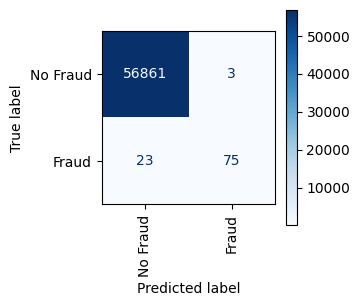

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.96      0.77      0.85        98

    accuracy                           1.00     56962
   macro avg       0.98      0.88      0.93     56962
weighted avg       1.00      1.00      1.00     56962

ExtraTreesClassifier (AP score: 0.8764 || Train CV AP Score: 0.8464)


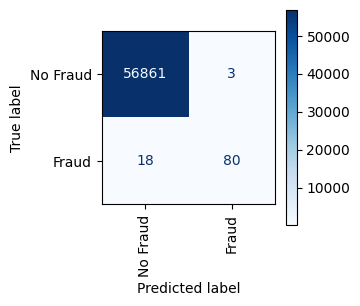

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.96      0.82      0.88        98

    accuracy                           1.00     56962
   macro avg       0.98      0.91      0.94     56962
weighted avg       1.00      1.00      1.00     56962

XGBClassifier (AP score: 0.8770 || Train CV AP Score: 0.8461)


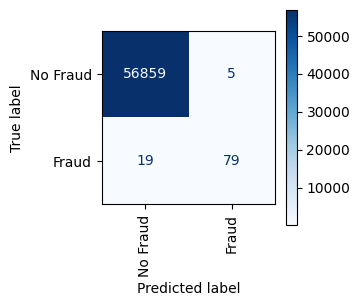

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.94      0.81      0.87        98

    accuracy                           1.00     56962
   macro avg       0.97      0.90      0.93     56962
weighted avg       1.00      1.00      1.00     56962

XGBRFClassifier (AP score: 0.8684 || Train CV AP Score: 0.8327)


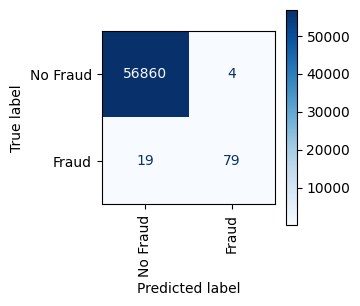

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.95      0.81      0.87        98

    accuracy                           1.00     56962
   macro avg       0.98      0.90      0.94     56962
weighted avg       1.00      1.00      1.00     56962

LogisticRegression (AP score: 0.7439 || Train CV AP Score: 0.7621)


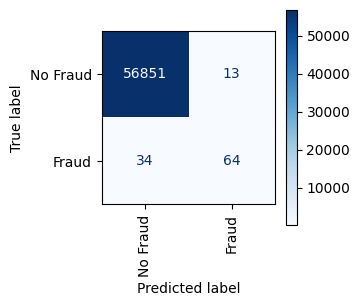

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.83      0.65      0.73        98

    accuracy                           1.00     56962
   macro avg       0.92      0.83      0.87     56962
weighted avg       1.00      1.00      1.00     56962

KNeighborsClassifier (AP score: 0.8079 || Train CV AP Score: 0.7785)


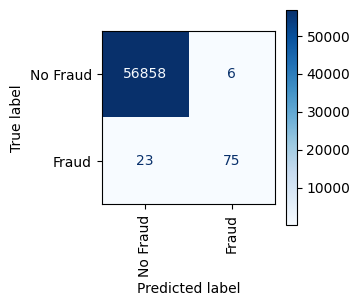

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.93      0.77      0.84        98

    accuracy                           1.00     56962
   macro avg       0.96      0.88      0.92     56962
weighted avg       1.00      1.00      1.00     56962

SGDClassifier (AP score: 0.6892 || Train CV AP Score: 0.7205)


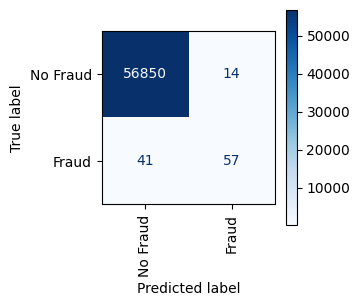

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.80      0.58      0.67        98

    accuracy                           1.00     56962
   macro avg       0.90      0.79      0.84     56962
weighted avg       1.00      1.00      1.00     56962



In [23]:
models = {"Random Forest":RandomForestClassifier(n_jobs=-1, random_state=rand_state),
          "Extra":ExtraTreesClassifier(n_jobs=-1),
          "XGB Classifier": xgb.XGBClassifier(eval_metric=average_precision_score, n_jobs=-1, tree_method="hist", random_state=rand_state),
          "XGB Random Forest Classifier": xgb.XGBRFClassifier(objective="binary:logistic", eval_metric=average_precision_score, tree_method="hist", random_state=rand_state),
          "Logistic Regression": LogisticRegression(n_jobs=-1),
          "KNN": KNeighborsClassifier(n_jobs=-1), 
          "SGD": SGDClassifier(n_jobs=-1, loss="log_loss")}
print_scores(models)

And try Voting Classifier.

In [24]:
clf_meta=xgb.XGBClassifier(eval_metric=average_precision_score, tree_method="hist")
classifiers_stack=[ExtraTreesClassifier(n_jobs=-1),
                   RandomForestClassifier(n_jobs=-1),
                   xgb.XGBClassifier(eval_metric=average_precision_score, n_jobs=-1, tree_method="hist", random_state=rand_state),
                   xgb.XGBRFClassifier(objective="binary:logistic", eval_metric=average_precision_score, n_jobs=-1, tree_method="hist", random_state=rand_state),
                   LogisticRegression(n_jobs=-1, class_weight="balanced"),
                   KNeighborsClassifier(n_jobs=-1),
                   SGDClassifier(loss="log_loss", n_jobs=-1, class_weight="balanced")]
clf_stack = StackingCVClassifier(classifiers=classifiers_stack,
                                 meta_classifier=clf_meta,
                                 cv=kf,
                                 verbose=False,
                                 use_probas=True,
                                 use_features_in_secondary=True)

StackingCVClassifier (AP score: 0.8834 || Train CV AP Score: 0.7523)


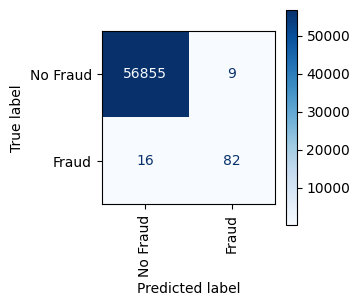

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.90      0.84      0.87        98

    accuracy                           1.00     56962
   macro avg       0.95      0.92      0.93     56962
weighted avg       1.00      1.00      1.00     56962



In [25]:
vc ={"Stack": clf_stack }
print_scores(vc, stack=True, result_prefix="_voting_stack")

#### Tuning

Now let's try tuning according to AP score.

In [ ]:
tree_clf_ap = tune_dec_tree()
log_reg_ap = tune_log_reg()
knears_neighbors_ap = tune_knn()
xgb_est_ap = tune_xgb()
sgd_est_ap = tune_sgd_bayes()
models_with_params={"Decision Tree": tree_clf_ap,
                    "KNN":log_reg_ap,
                    "Logistic Regression": knears_neighbors_ap ,
                    "XGB": xgb_est_ap, 
                    "SGD":sgd_est_ap}
print_scores(models_with_params,result_prefix="_tuned_ap")

In [ ]:
classifiers=[("SGD", tree_clf_ap),
             ("XGB Classifier", log_reg_ap),
             ("Logistic Regression", knears_neighbors_ap),
             ("Decision Tree", xgb_est_ap),
             ("KNN", sgd_est_ap)]

vc ={"Vote": VotingClassifier(estimators=classifiers,voting="soft",
                              n_jobs=-1,weights=[2,1,2,1,0.1]) }#We arranged weights according to results    
print_scores(vc, result_prefix="_voting_tuned_ap")

In [ ]:
classifiers_tuned_ap=[tree_clf_ap,log_reg_ap,knears_neighbors_ap,xgb_est_ap,sgd_est_ap]
clf_stack_tuned_ap=StackingCVClassifier(classifiers=classifiers_tuned_ap,
                                 meta_classifier=clf_meta,
                                 cv=kf,
                                 verbose=False,
                                 use_probas=True,
                                 use_features_in_secondary=True)
vc ={"Stack": clf_stack_tuned_ap }
print_scores(vc, stack=True, result_prefix="_voting_stack_tuned_ap")

## Oversampling

If we apply SMOTE(It's a oversampling algorithm technique for imbalanced datasets.):

In [26]:
method = SMOTE(random_state=rand_state)
X_train_resampled, y_train_resampled = method.fit_resample(X_train_scaled, y_train)

RandomForestClassifier (AP score: 0.8776 || Train CV AP Score: 0.6996)


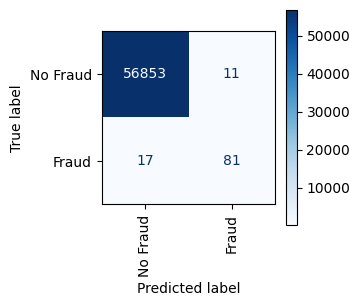

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.88      0.83      0.85        98

    accuracy                           1.00     56962
   macro avg       0.94      0.91      0.93     56962
weighted avg       1.00      1.00      1.00     56962

ExtraTreesClassifier (AP score: 0.8727 || Train CV AP Score: 0.7357)


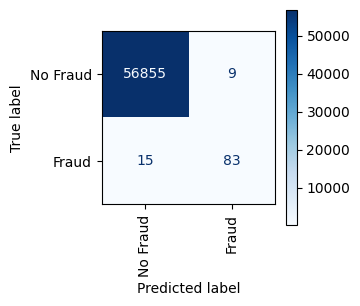

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.90      0.85      0.87        98

    accuracy                           1.00     56962
   macro avg       0.95      0.92      0.94     56962
weighted avg       1.00      1.00      1.00     56962

XGBClassifier (AP score: 0.8738 || Train CV AP Score: 0.6141)


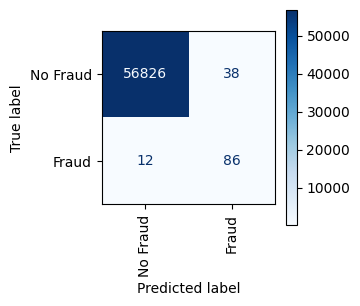

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.69      0.88      0.77        98

    accuracy                           1.00     56962
   macro avg       0.85      0.94      0.89     56962
weighted avg       1.00      1.00      1.00     56962

XGBRFClassifier (AP score: 0.7038 || Train CV AP Score: 0.0929)


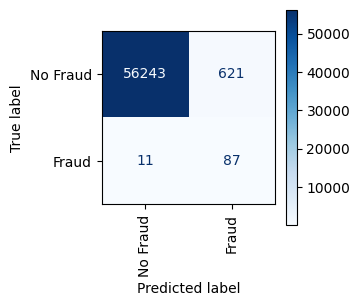

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.12      0.89      0.22        98

    accuracy                           0.99     56962
   macro avg       0.56      0.94      0.61     56962
weighted avg       1.00      0.99      0.99     56962

LogisticRegression (AP score: 0.7212 || Train CV AP Score: 0.0526)


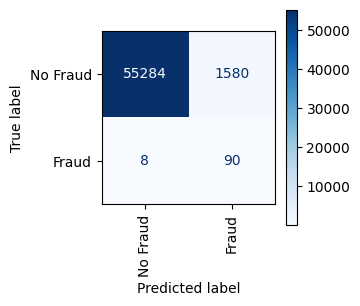

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.05      0.92      0.10        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.54     56962
weighted avg       1.00      0.97      0.98     56962

KNeighborsClassifier (AP score: 0.4902 || Train CV AP Score: 0.3088)


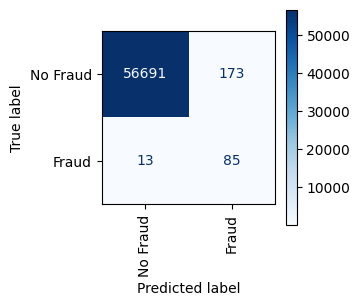

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.33      0.87      0.48        98

    accuracy                           1.00     56962
   macro avg       0.66      0.93      0.74     56962
weighted avg       1.00      1.00      1.00     56962

SGDClassifier (AP score: 0.7251 || Train CV AP Score: 0.0506)


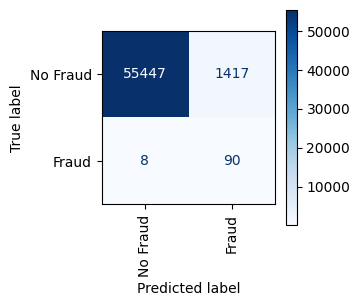

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962



In [27]:
models = {"Random Forest":RandomForestClassifier(n_jobs=-1, random_state=rand_state),
          "Extra Trees":ExtraTreesClassifier(n_jobs=-1),
          "XGB Classifier": xgb.XGBClassifier(eval_metric=average_precision_score, n_jobs=-1, tree_method="hist", random_state=rand_state),
          "XGB Random Forest Classifier": xgb.XGBRFClassifier(objective="binary:logistic", eval_metric=average_precision_score, tree_method="hist", random_state=rand_state),
          "Logistic Regression": LogisticRegression(n_jobs=-1),
          "KNN": KNeighborsClassifier(n_jobs=-1), 
          "SGD": SGDClassifier(n_jobs=-1, loss="log_loss")}
print_scores(models, X_train=X_train_resampled, y_train=y_train_resampled, oversample=True, result_prefix="_smote")

VotingClassifier (AP score: 0.8762 || Train CV AP Score: 0.6260)


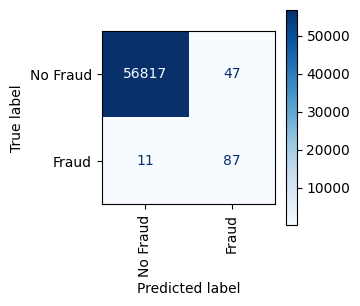

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.65      0.89      0.75        98

    accuracy                           1.00     56962
   macro avg       0.82      0.94      0.87     56962
weighted avg       1.00      1.00      1.00     56962



In [28]:
classifiers =[("Extra Trees", ExtraTreesClassifier(n_jobs=-1)),
              ("Random Forest", RandomForestClassifier(n_jobs=-1)),
              ("XGB Classifier", xgb.XGBClassifier(eval_metric=average_precision_score, n_jobs=-1, tree_method="hist")), 
              ("XGB Random Forest Classifier", xgb.XGBRFClassifier(objective="binary:logistic", eval_metric=average_precision_score, n_jobs=-1, tree_method="hist")),
              ("Logistic Regression", LogisticRegression(n_jobs=-1)), 
              ("KNN", KNeighborsClassifier(n_jobs=-1)), 
              ("Decision Tree", DecisionTreeClassifier()),
              ("SGD", SGDClassifier(loss="log_loss", n_jobs=-1))]

vc ={"Vote": VotingClassifier(estimators=classifiers,voting="soft",n_jobs=-1) } 
print_scores(vc, X_train=X_train_resampled, y_train=y_train_resampled, oversample=True, result_prefix="_voting_smote")

StackingCVClassifier (AP score: 0.7298 || Train CV AP Score: 0.5696)


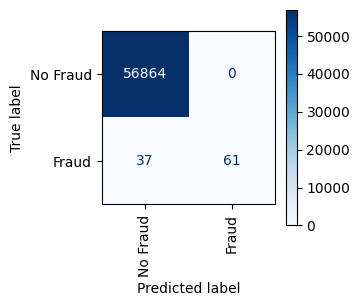

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       1.00      0.62      0.77        98

    accuracy                           1.00     56962
   macro avg       1.00      0.81      0.88     56962
weighted avg       1.00      1.00      1.00     56962



In [29]:
vc ={"Stack": clf_stack }
print_scores(vc, X_train=X_train_resampled, y_train=y_train_resampled, oversample=True, result_prefix="_voting_stack_smote")

#### Tuning

Let's see if we can get any better by tuning.

In [ ]:
log_reg_smote_ap = tune_log_reg(X=X_train_resampled, y=y_train_resampled)
tree_clf_smote_ap = tune_dec_tree(X=X_train_resampled, y=y_train_resampled)
knears_neighbors_smote_ap = tune_knn(X=X_train_resampled, y=y_train_resampled)
xgb_est_smote_ap = tune_xgb(X=X_train_resampled, y=y_train_resampled)
models_with_params={"Decision Tree": tree_clf_smote_ap,
                    "KNN": knears_neighbors_smote_ap,
                    "Logistic Regression": log_reg_smote_ap,
                    "XGB": xgb_est_smote_ap}
print_scores(models_with_params, X_train=X_train_resampled, y_train=y_train_resampled, oversample=True, result_prefix="_smote_tuned_ap")

In [ ]:
classifiers =[("XGB Classifier", xgb_est_smote_ap),
                 ("Logistic Regression", log_reg_smote_ap),
                 ("KNN", knears_neighbors_smote_ap),
                 ("Decision Tree", tree_clf_smote_ap)]
vc ={"Vote": VotingClassifier(estimators=classifiers,voting="soft",n_jobs=-1) }    
print_scores(vc, X_train=X_train_resampled, y_train=y_train_resampled, oversample=True, result_prefix="_voting_smote_tuned_ap")

## Undersampling

First we'll do random undersampling for dimensionality reduction and correlation matrix then use Near Miss algorithm for actual undersampling modeling.

In [30]:
X_scaled_for_rus = credit_card.drop(columns="Class")
y_scaled_for_rus = credit_card.Class
X_scaled_for_rus = scaler.fit_transform(X_scaled_for_rus)

In [31]:
rus=RandomUnderSampler(random_state=rand_state)
X_rus, y_rus=rus.fit_resample(X_scaled_for_rus, y_scaled_for_rus)

In [32]:
Counter(y_rus)

Counter({0: 492, 1: 492})

#### If we apply Dimensionality Reduction techniques:

In [33]:
# T-SNE Implementation
X_reduced_tsne = TSNE(n_components=2, random_state=rand_state, n_jobs=-1).fit_transform(X_rus)

# PCA Implementation
X_reduced_pca = PCA(n_components=2, random_state=rand_state).fit_transform(X_rus)

# TruncatedSVD
X_reduced_svd = TruncatedSVD(n_components=2, random_state=rand_state).fit_transform(X_rus)

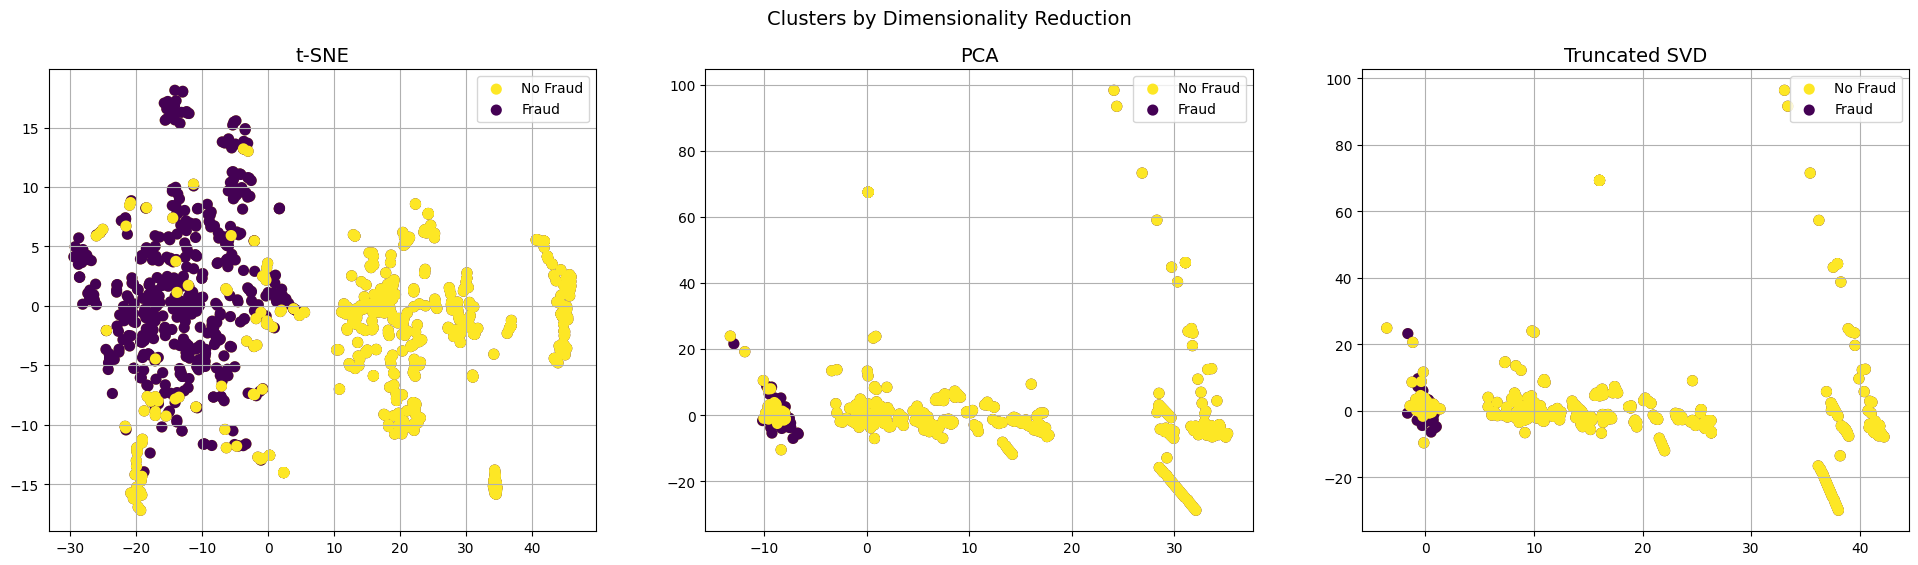

In [35]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
f.suptitle('Clusters by Dimensionality Reduction', fontsize=14)

# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y_rus == 0), label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y_rus == 1), label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)
ax1.grid(True)
ax1.legend()

# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y_rus == 0), label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y_rus == 1), label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)
ax2.grid(True)
ax2.legend()

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y_rus == 0), label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y_rus == 1), label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)
ax3.grid(True)
ax3.legend()

plt.show()

#### Let's apply NearMiss(It's a undersampling algorithm technique for imbalanced datasets.):

In [36]:
nm = NearMiss()
X_train_nm, y_train_nm = nm.fit_resample(X_train, y_train)

In [37]:
Counter(y_train_nm)

Counter({0: 394, 1: 394})

In [38]:
new_df=pd.DataFrame(X_train_nm)
new_df["Class"]=y_train_nm

See correlation matrix. (We did this right after undersampling to see correlations clearly.)

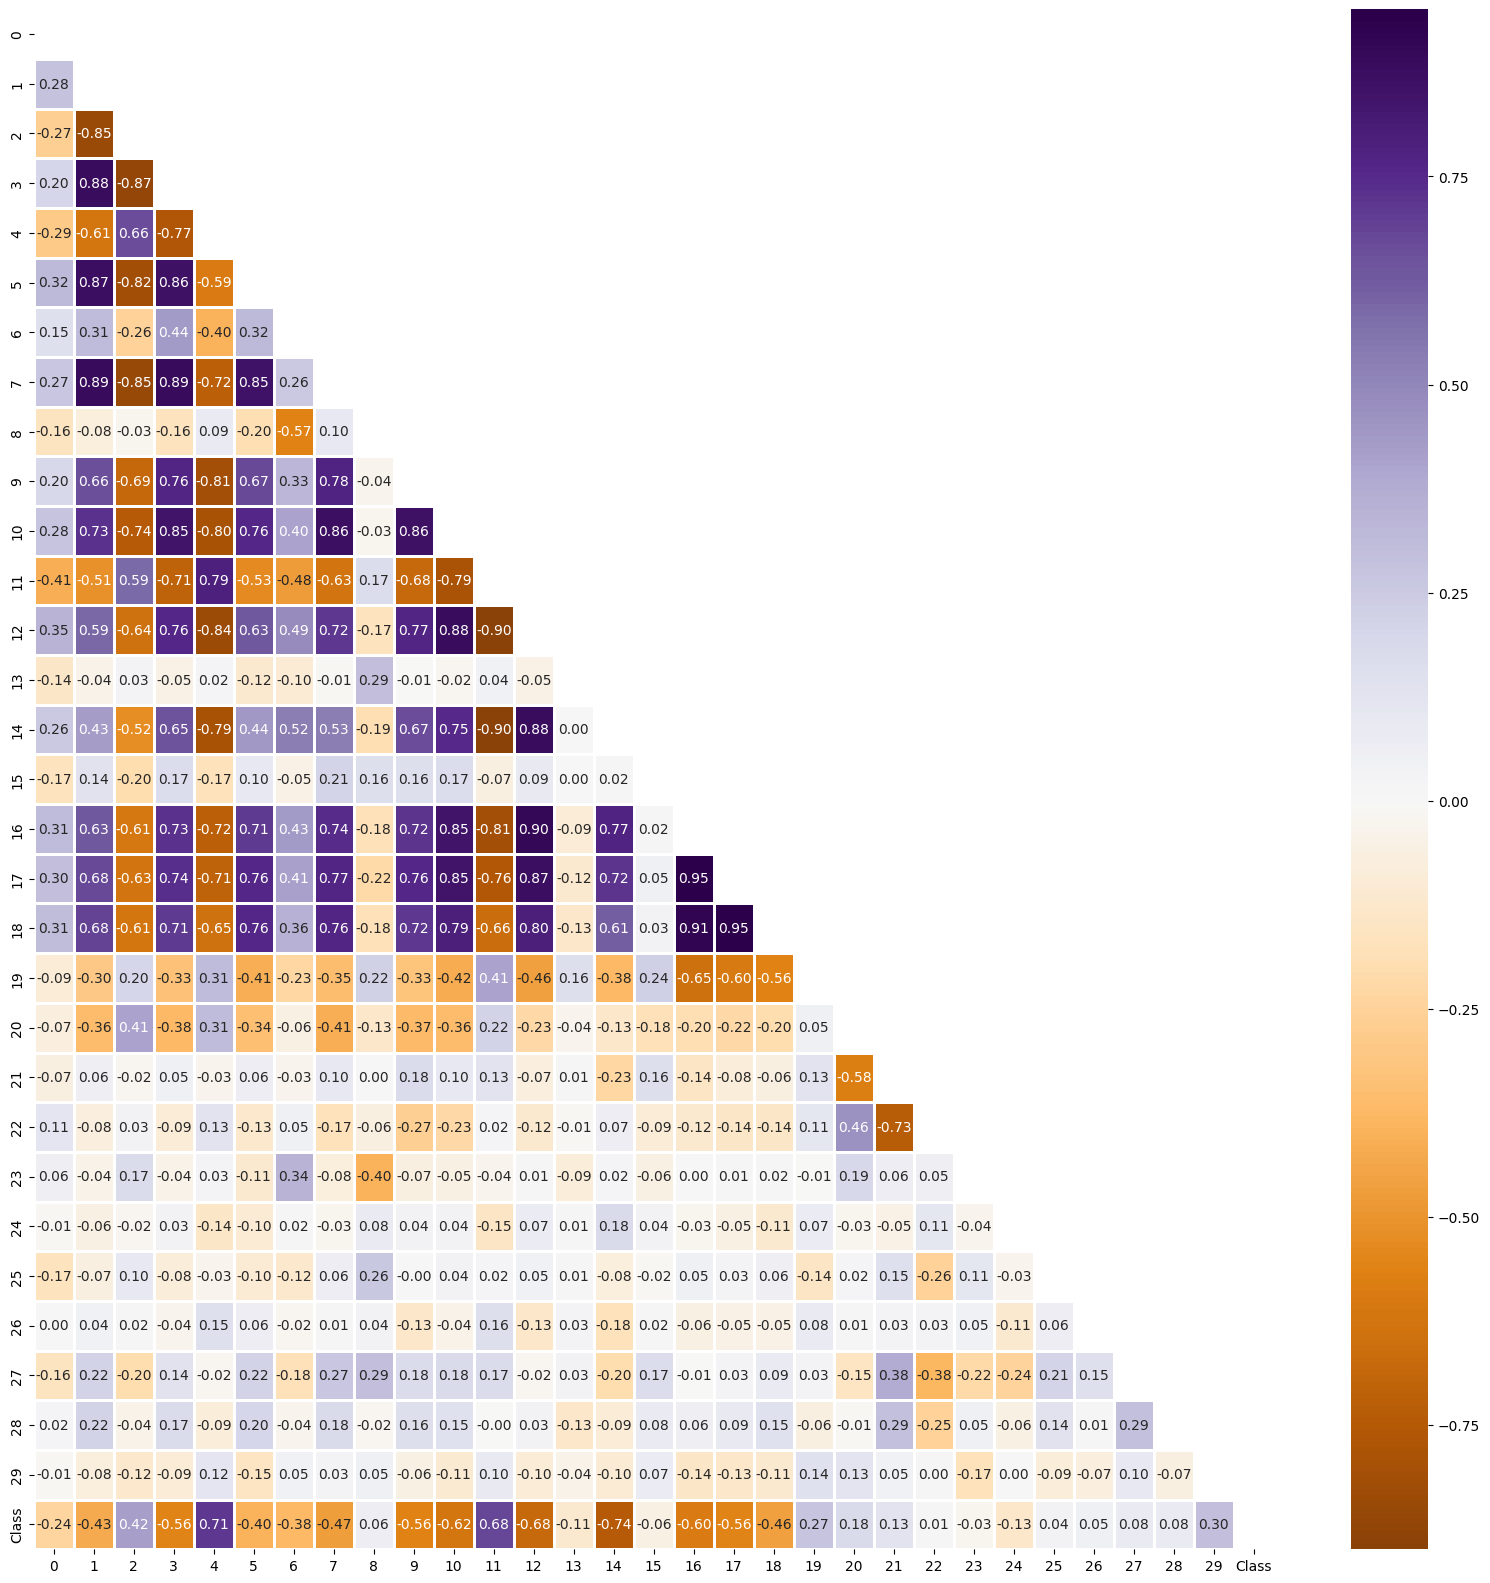

In [39]:
plt.figure(figsize = (20,20))
corr = new_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))# Generate a mask for the upper triangle 
ax = sns.heatmap(corr, cmap='PuOr', mask=mask, center=0, linewidths=1, annot=True, fmt=".2f")
plt.show()

Now try algorithms and Voting Classifier:

RandomForestClassifier (AP score: 0.6699 || Train CV AP Score: 0.0018)


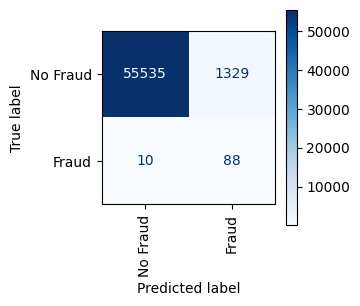

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.90      0.12        98

    accuracy                           0.98     56962
   macro avg       0.53      0.94      0.55     56962
weighted avg       1.00      0.98      0.99     56962

ExtraTreesClassifier (AP score: 0.5312 || Train CV AP Score: 0.0018)


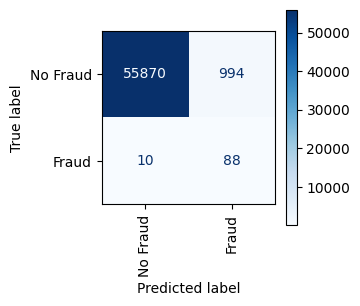

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.08      0.90      0.15        98

    accuracy                           0.98     56962
   macro avg       0.54      0.94      0.57     56962
weighted avg       1.00      0.98      0.99     56962

XGBClassifier (AP score: 0.4916 || Train CV AP Score: 0.0019)


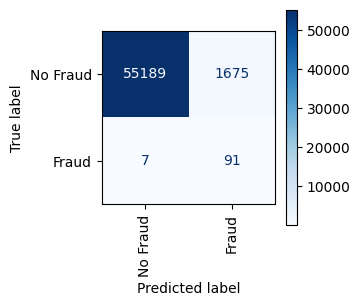

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     56864
           1       0.05      0.93      0.10        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.54     56962
weighted avg       1.00      0.97      0.98     56962

XGBRFClassifier (AP score: 0.6234 || Train CV AP Score: 0.0022)


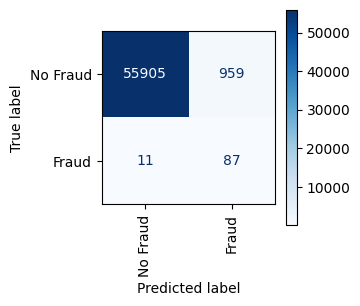

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.08      0.89      0.15        98

    accuracy                           0.98     56962
   macro avg       0.54      0.94      0.57     56962
weighted avg       1.00      0.98      0.99     56962

LogisticRegression (AP score: 0.1298 || Train CV AP Score: 0.0038)


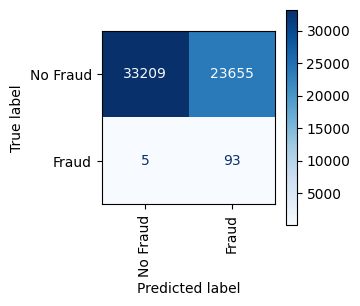

              precision    recall  f1-score   support

           0       1.00      0.58      0.74     56864
           1       0.00      0.95      0.01        98

    accuracy                           0.58     56962
   macro avg       0.50      0.77      0.37     56962
weighted avg       1.00      0.58      0.74     56962

KNeighborsClassifier (AP score: 0.0233 || Train CV AP Score: 0.0084)


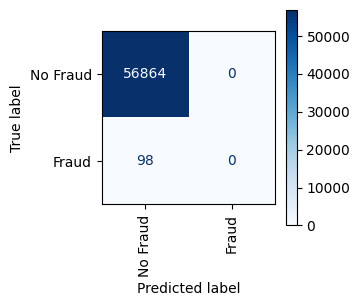

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.00      0.00      0.00        98

    accuracy                           1.00     56962
   macro avg       0.50      0.50      0.50     56962
weighted avg       1.00      1.00      1.00     56962

DecisionTreeClassifier (AP score: 0.0020 || Train CV AP Score: 0.0020)


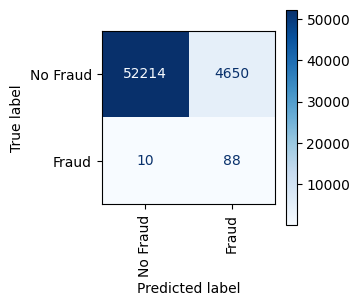

              precision    recall  f1-score   support

           0       1.00      0.92      0.96     56864
           1       0.02      0.90      0.04        98

    accuracy                           0.92     56962
   macro avg       0.51      0.91      0.50     56962
weighted avg       1.00      0.92      0.96     56962

SGDClassifier (AP score: 0.0152 || Train CV AP Score: 0.0032)


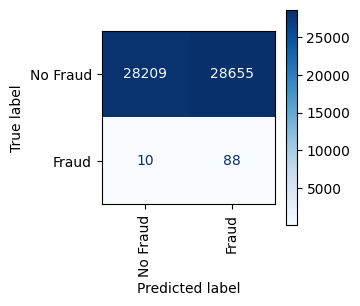

              precision    recall  f1-score   support

           0       1.00      0.50      0.66     56864
           1       0.00      0.90      0.01        98

    accuracy                           0.50     56962
   macro avg       0.50      0.70      0.33     56962
weighted avg       1.00      0.50      0.66     56962

SVC (AP score: 0.2123 || Train CV AP Score: 0.0050)


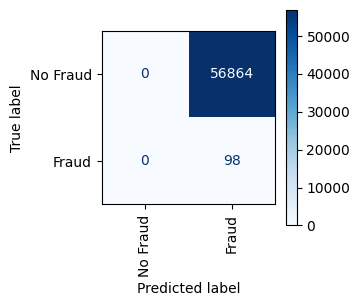

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     56864
           1       0.00      1.00      0.00        98

    accuracy                           0.00     56962
   macro avg       0.00      0.50      0.00     56962
weighted avg       0.00      0.00      0.00     56962



In [40]:
models = {"Random Forest":RandomForestClassifier(n_jobs=-1, random_state=rand_state),
          "Extra":ExtraTreesClassifier(n_jobs=-1),
          "XGB Classifier": xgb.XGBClassifier(eval_metric=average_precision_score, n_jobs=-1, tree_method="hist", random_state=rand_state),
          "XGB Random Forest Classifier": xgb.XGBRFClassifier(objective="binary:logistic", eval_metric=average_precision_score, n_jobs=-1, tree_method="hist", random_state=rand_state),
          "Logistic Regression": LogisticRegression(n_jobs=-1),
          "KNN": KNeighborsClassifier(n_jobs=-1), 
          "Decision Tree": DecisionTreeClassifier(),
          "SGD": SGDClassifier(loss="log_loss", n_jobs=-1),
          "Support Vector Classifier":SVC(probability=True)}
print_scores(models, X_train=X_train_nm, y_train=y_train_nm, undersample=True, result_prefix="_us")

StackingCVClassifier (AP score: 0.2661 || Train CV AP Score: 0.0018)


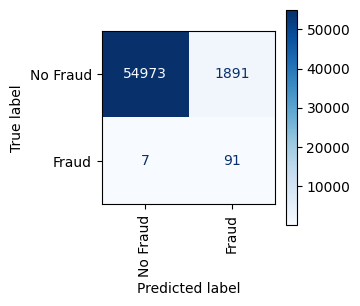

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     56864
           1       0.05      0.93      0.09        98

    accuracy                           0.97     56962
   macro avg       0.52      0.95      0.54     56962
weighted avg       1.00      0.97      0.98     56962



In [41]:
vc ={"Stack": clf_stack }
print_scores(vc, X_train=X_train_nm, y_train=y_train_nm, undersample=True, result_prefix="_voting_stack_us")

Last but not least. Let's try TPOT. It's is a Python Automated Machine Learning tool that optimizes machine learning pipelines using genetic programming. Let's try it.



TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.
Best pipeline: GradientBoostingClassifier(input_matrix, learning_rate=0.5, max_depth=1, max_features=0.6500000000000001, min_samples_leaf=5, min_samples_split=6, n_estimators=100, subsample=1.0)
Best pipeline: GaussianNB(RFE(input_matrix, criterion=gini, max_features=0.1, n_estimators=100, step=0.35000000000000003))
Best pipeline: GradientBoostingClassifier(PCA(MLPClassifier(input_matrix, alpha=0.01, learning_rate_init=0.001), iterated_power=5, svd_solver=randomized), learning_rate=0.01, max_depth=6, max_features=0.4, min_samples_leaf=1, min_samples_split=13, n_estimators=100, subsample=0.1)
Best pipeline: RandomForestClassifier(input_matrix, bootstrap=False, criterion=entropy, max_features=0.1, min_samples_leaf=13, min_samples_split=4, n_estimators=100)
Best pipeline: GradientBoostingClassifier(input_matrix, learning_rate=0.01, max_depth=5, max_features=0.2, min_samples_le

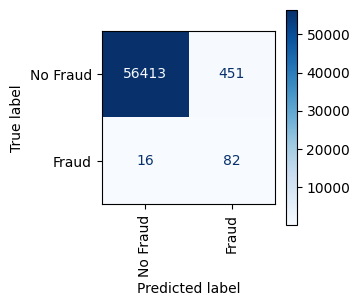

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56864
           1       0.15      0.84      0.26        98

    accuracy                           0.99     56962
   macro avg       0.58      0.91      0.63     56962
weighted avg       1.00      0.99      0.99     56962



In [55]:
TPOT_model_us = TPOTClassifier(generations=3,offspring_size=30, scoring='average_precision', cv=kf,
                                 population_size=30, verbosity=1, n_jobs=-1, random_state=rand_state)
models = {"TPOT": TPOT_model_us}
print_scores(models, X_train=X_train_nm, y_train=y_train_nm, undersample=True, result_prefix="_us_TPOT")

In [50]:
TPOT_model_us.fitted_pipeline_

Pipeline(steps=[('extratreesclassifier',
                 ExtraTreesClassifier(max_features=0.7500000000000001,
                                      min_samples_leaf=2, random_state=42))])

In [60]:
pd.set_option('display.float_format', '{:.3f}'.format)
results.style.highlight_max(subset=["Precision-Recall Score","ROC-AUC Score","Train CV AP Score"],color = 'lightgreen')

,Function Name,Accuracy,Precision,Recall,F1,TN,FP,FN,TP,ROC-AUC Score,Precision-Recall Score,Train CV AP Score
0,RandomForestClassifier,0.999544,0.961538,0.765306,0.852273,56861,3,23,75,0.921852,0.869103,0.842750
1,ExtraTreesClassifier,0.999631,0.963855,0.816327,0.883978,56861,3,18,80,0.957676,0.876447,0.846385
2,XGBClassifier,0.999579,0.940476,0.806122,0.868132,56859,5,19,79,0.977606,0.876994,0.846074
3,XGBRFClassifier,0.999596,0.951807,0.806122,0.872928,56860,4,19,79,0.971056,0.868406,0.832682
4,LogisticRegression,0.999175,0.831169,0.653061,0.731429,56851,13,34,64,0.956156,0.743856,0.762123
5,KNeighborsClassifier,0.999491,0.925926,0.765306,0.837989,56858,6,23,75,0.933505,0.807854,0.778527
6,SGDClassifier,0.999034,0.802817,0.581633,0.674556,56850,14,41,57,0.976570,0.689245,0.720512
7,StackingCVClassifier_voting_stack,0.999561,0.901099,0.836735,0.867725,56855,9,16,82,0.977945,0.883379,0.752349
8,RandomForestClassifier_smote,0.999508,0.880435,0.826531,0.852632,56853,11,17,81,0.968200,0.877629,0.699624
9,ExtraTreesClassifier_smote,0.999579,0.902174,0.846939,0.873684,56855,9,15,83,0.973744,0.872682,0.735707


Best results highlited. I will be waiting for your feedback :)

In [54]:
results.to_excel('results_4.10.2.xls', index=False)